In [80]:
BATCH_SIZE = 4
EDGE_CROP = 16
NB_EPOCHS = 20
GAUSSIAN_NOISE = 0.1
UPSAMPLE_MODE = 'SIMPLE'
# downsampling inside the network
NET_SCALING = None
# downsampling in preprocessing
IMG_SCALING = (1, 1)
# number of validation images to use
VALID_IMG_COUNT= 4
VALIDATION_COUNT_PCT= 0.001
# maximum number of steps_per_epoch in training
MAX_TRAIN_STEPS = 500
AUGMENT_BRIGHTNESS = False

In [81]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from skimage.io import imread
import matplotlib.pyplot as plt
import os
import gc; gc.enable() # memory is tight
import tensorflow as tf

In [82]:
ship_dir = '/mnt/fsx/airbus_data/deep_learning_v2'
train_image_dir = os.path.join(ship_dir, 'train')
from skimage.morphology import label

In [83]:
from skimage.morphology import label
def multi_rle_encode(img):
    labels = label(img[:, :, 0])
    return [rle_encode(labels==k) for k in np.unique(labels[labels>0])]

def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.T.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

def masks_as_image(in_mask_list):
    # Take the individual ship masks and create a single mask array for all ships
    all_masks = np.zeros((768, 768), dtype = np.int16)
    #if isinstance(in_mask_list, list):
    for mask in in_mask_list:
        if isinstance(mask, str):
            all_masks += rle_decode(mask)
    return np.expand_dims(all_masks, -1)


In [84]:
masks = pd.read_csv(os.path.join(ship_dir,
                                 'train_ship_segmentations_train.csv.exp'))
print(masks.shape[0], 'masks found')
print(masks['ImageId'].value_counts().shape[0])
print(masks.head())

999 masks found
519
                                             ImageId  \
0  000155de5_f6248d89-63c8-4b6b-bf48-bc76a1113538...   
1  000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...   
2  000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...   
3  000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...   
4  000194a2d_8d25adc5-48c0-4d7b-97ec-7d40cfc084a3...   

                                       EncodedPixels  
0  287464 2 288232 4 288999 7 289767 9 290535 12 ...  
1  93243 2 94008 6 94774 8 95542 8 96310 9 97079 ...  
2  370690 2 371457 4 371462 2 372226 6 372993 6 3...  
3  189490 4 190255 7 191021 10 191790 9 192558 9 ...  
4  244036 2 244800 7 245567 8 246333 10 247098 14...  


In [85]:
def make_image_gen(in_df, batch_size = BATCH_SIZE):
    all_batches = list(in_df.groupby('ImageId'))
    out_masks = []
    idx = 0
    while True:
        for c_img_id, c_masks in all_batches:
            all_masks = []
            for v in c_masks['EncodedPixels'].values:
                all_masks.extend(v.split(" "))
            grouped_masks = " ".join(all_masks)
            out_masks.append([ c_img_id, grouped_masks])            
            idx += 1
            if idx>=batch_size:
                yield out_masks
                idx = 0
                out_mask=[]

In [86]:
train_gen = make_image_gen(masks)
grouped_masks = next(train_gen)
df = pd.DataFrame(grouped_masks, columns = ['ImageId', 'EncodedPixels'])
df.to_csv('/mnt/fsx/airbus_data/deep_learning_v2/processing/output/test.csv', index=False)

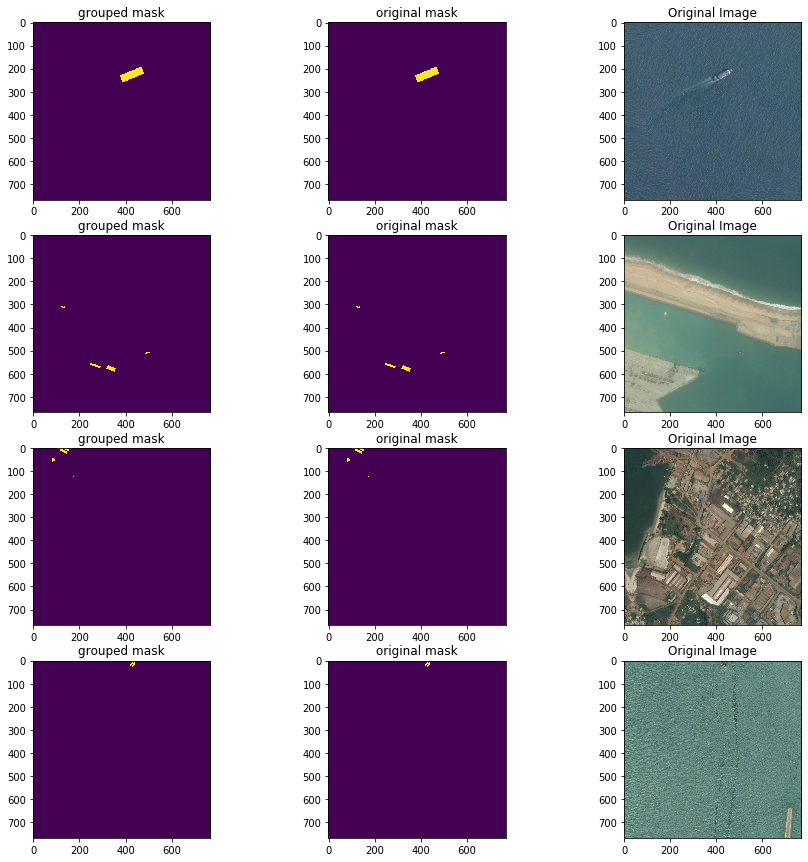

In [101]:
masks1 = pd.read_csv('/mnt/fsx/airbus_data/deep_learning_v2/processing/output/test.csv')
masks2 = pd.read_csv('/mnt/fsx/airbus_data/deep_learning_v2/train_ship_segmentations_train.csv.exp')
total_pics = len(masks1['ImageId'].values)
fig, axs = plt.subplots(total_pics, 3, figsize=(15,15))
idx = 0
for test_img_name in masks1['ImageId'].values:
  rle_0 = masks1.query('ImageId=="{}"'.format(test_img_name))['EncodedPixels'] # an efficient way to filter against pandas dataframe
  img_0 = masks_as_image(rle_0)
  axs[idx, 0].imshow(img_0[:, :, 0])
  axs[idx, 0].set_title('grouped mask')
    
  rle_1 = masks1.query('ImageId=="{}"'.format(test_img_name))['EncodedPixels'] # an efficient way to filter against pandas dataframe
  img_1 = masks_as_image(rle_1)
  axs[idx, 1].imshow(img_1[:, :, 0])
  axs[idx, 1].set_title('original mask')
  
  orig_img = plt.imread(os.path.join(train_image_dir, test_img_name))
  axs[idx, 2].imshow(orig_img)
  axs[idx, 2].set_title('Original Image')
  idx+=1